<h1>Car Accident Severity Data Analysis Report</h1>
<p>This notebook is a capstone project report for the Applied Data Science specialization on Coursera.</p>
<p>The project follows CRISP-DM methodology and the report is structured accordingly.</p>

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#business_problem">Introduction / Business Understanding</a>
    <li><a href="#data">Data Understanding</a></li>
    <li><a href="#methodology">Methodology</a></li>
    <li><a href="#model_development">Model Development</a></li>
    <li><a href="#results">Results</a></li>
    <li><a href="#discussion">Discussion</a></li>
    <li><a href="#conclusion">Conclusion</a></li>
</ol>
</div>
<hr>

<h3 id="business_problem">Introduction / Business Understanding</h3>
<p>Even though Canada is among the leading countries regarding road traffic safety, there are countries which do much better. This fact means there is still room for growth.</p>
<p>The goals of the project are to analyse the car accidents dataset, to build a prediction model for the car accident severity in order to provide data-based understanding of the main factors defining car accident severity.</p>
<p><b>Target audience:</b></p>
<p>There are two audiences who might be interested in the results of this analysis.</p>
<ul>
    <li>Road and traffic designers: urban planners, road designers, traffic law makers and controllers (policemen)
    <li>Regular people, drivers
</ul>
<p>
Having understanding of the impact of various factors on the car accidents severity:<br>
- The first group will be able to design safer road and traffic configuration and rules<br>
- The second group will better understand the risks of driving under various conditions and plan their trips accordingly
</p>

<h3 id="data">Data understanding</h3>
<p>We use <a href="https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a">National Collision Database</a> dataset. The copy of <b>the dataset and the data dictionary</b> are available in the <a href="https://github.com/mikevostrikov/202008-coursera-applied-data-science-capstone/tree/master/data">github repository</a> of the current project.</p>
<p>The dataset contains 19 years of car accidents history. We will limit our analysis to the last 10 years only.</p>
<p>There are the following attributes in the dataset:</p>
<table>
    <tr><th>Column</th><th>Description</th></tr>
    <tr><td>C_YEAR</td><td>Year</td></tr>
    <tr><td>C_MNTH</td><td>Month</td></tr>
    <tr><td>C_WDAY</td><td>Day of week</td></tr>
    <tr><td>C_HOUR</td><td>Collision hour</td></tr>
    <tr><td>C_SEV</td><td>Collision severity</td></tr>
    <tr><td>C_CONF</td><td>Collision configuration</td></tr>
    <tr><td>C_RCFG</td><td>Roadway configuration</td></tr>
    <tr><td>C_WTHR</td><td>Weather condition</td></tr>
    <tr><td>C_RSUR</td><td>Road surface</td></tr>
    <tr><td>C_RALN</td><td>Road alignment</td></tr>
    <tr><td>C_TRAF</td><td>Traffic control</td></tr>
    <tr><td>C_CASE</td><td>Accident unique ID</td></tr>
</table>
<p>The attributes values are encoded: instead of text you will see in the dataset values like '01', '02' etc. These values are described in the <a href="https://github.com/mikevostrikov/202008-coursera-applied-data-science-capstone/tree/master/data">data dictionary</a>.</p>
<p>We will try to predict the value of C_SEV (Severity) target variable based on other variables available.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

df_iter_csv = pd.read_csv(
    "https://raw.githubusercontent.com/mikevostrikov/202008-coursera-applied-data-science-capstone/master/data/NCDB_1999_to_2017.zip",
    #'data/NCDB_1999_to_2017.zip',
    iterator=True,
    chunksize=1000,
    usecols=('C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_SEV','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','C_CASE'),
    dtype={'C_YEAR':int,'C_MNTH':str,'C_WDAY':str,'C_HOUR':str,'C_SEV':str,'C_RCFG':str,'C_WTHR':str,'C_RSUR':str,'C_RALN':str,'C_TRAF':str,'C_CASE':int}
)
df = pd.concat([chunk[chunk['C_YEAR'] >= 2006] for chunk in df_iter_csv])
df = (
  df.drop_duplicates()
  .rename(columns={'C_YEAR':'Year','C_MNTH':'Month','C_WDAY':'Weekday','C_HOUR':'Hour','C_SEV':'Severity','C_RCFG':'Roadway','C_WTHR':'Weather','C_RSUR':'Surface','C_RALN':'Alignment','C_TRAF':'TrafficControl'})
  .set_index('C_CASE')
)
df.index.name = None
df.head()

,Year,Month,Weekday,Hour,Severity,Roadway,Weather,Surface,Alignment,TrafficControl
1063702,2006,01,1,18,2,UU,1,3,2,18
1063774,2006,01,1,19,2,UU,1,5,1,UU
1063857,2006,01,1,12,2,02,2,1,1,01
1063877,2006,01,1,13,2,UU,2,4,1,18
1063909,2006,01,1,11,2,UU,6,5,1,18


<h4>Data formats:</h4>

In [2]:
df.dtypes

Year               int32
Month             object
Weekday           object
Hour              object
Severity          object
Roadway           object
Weather           object
Surface           object
Alignment         object
TrafficControl    object
dtype: object

<h4>Handling missing data</h4>
<p>According to the Data Dictionary values 'QQ','Q','UU','U' are used in the dataset for different kinds of unknown values. In the context of this analysis the values are considered to be missing.</p>

In [3]:
(df
  .replace(['QQ','Q','UU','U'],np.nan)
  .notnull()
  .melt(value_vars=df.columns)
  .value_counts()
  .to_frame('counts')
  .reset_index()
  .pivot(index='variable',columns='value',values='counts'))

value,False,True
variable,,
Alignment,99543.0,1407007.0
Hour,15587.0,1490963.0
Month,75.0,1506475.0
Roadway,159797.0,1346753.0
Severity,NaN,1506550.0
Surface,63949.0,1442601.0
TrafficControl,93116.0,1413434.0
Weather,25934.0,1480616.0
Weekday,159.0,1506391.0


<p>Missing data is not a big part of the dataset, so we have luxury of dropping the rows with missing data altogether.</p>

In [4]:
df.replace(['QQ','Q','UU','U'],np.nan,inplace=True)
df.dropna(inplace=True)

<h4>Data balancing</h4>
<p>There are many more observations for severity '2' compared to the severity '1'. The dataset is unbalanced. Unbalanced data leads to bad-quality predictions. Let us balance the dataset by taking the same number of observations for every value of the target variable.</p>

In [5]:
df['Severity'].value_counts()

2    1196548
1      18728
Name: Severity, dtype: int64

In [6]:
g = df.groupby('Severity')
df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)).reset_index(drop=True)

In [7]:
df.describe(include='all')

,Year,Month,Weekday,Hour,Severity,Roadway,Weather,Surface,Alignment,TrafficControl
count,37456.000000,37456,37456,37456,37456,37456,37456,37456,37456,37456
unique,NaN,12,7,24,2,10,7,9,6,17
top,NaN,07,5,16,2,01,1,1,1,18
freq,NaN,3838,6098,2715,18728,20589,26532,26222,26041,25315
mean,2011.163365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.502370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2006.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2011.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2014.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


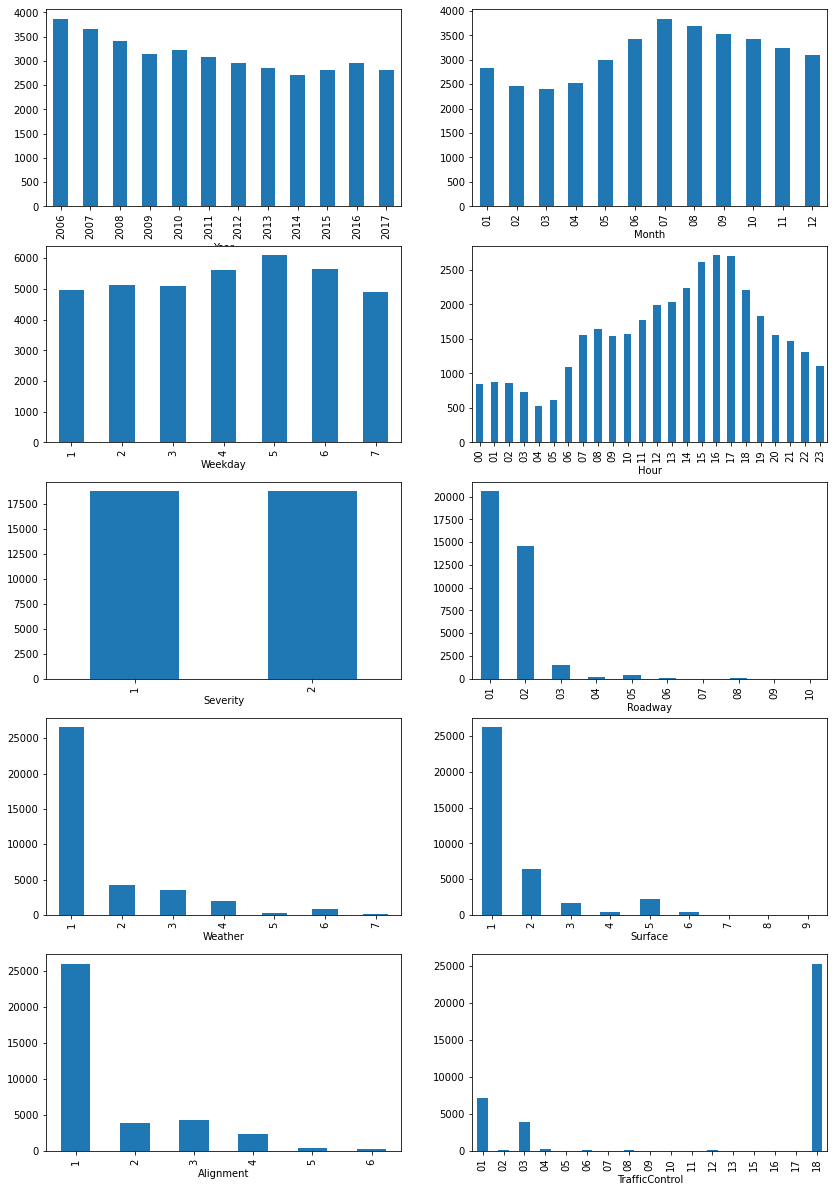

In [8]:
fig = plt.figure(figsize=(14,21))
for i, c in enumerate(df.columns):
    ax = fig.add_subplot(5, 2, i + 1)
    ax.set_xlabel(c)
    df[c].value_counts().sort_index().plot.bar()

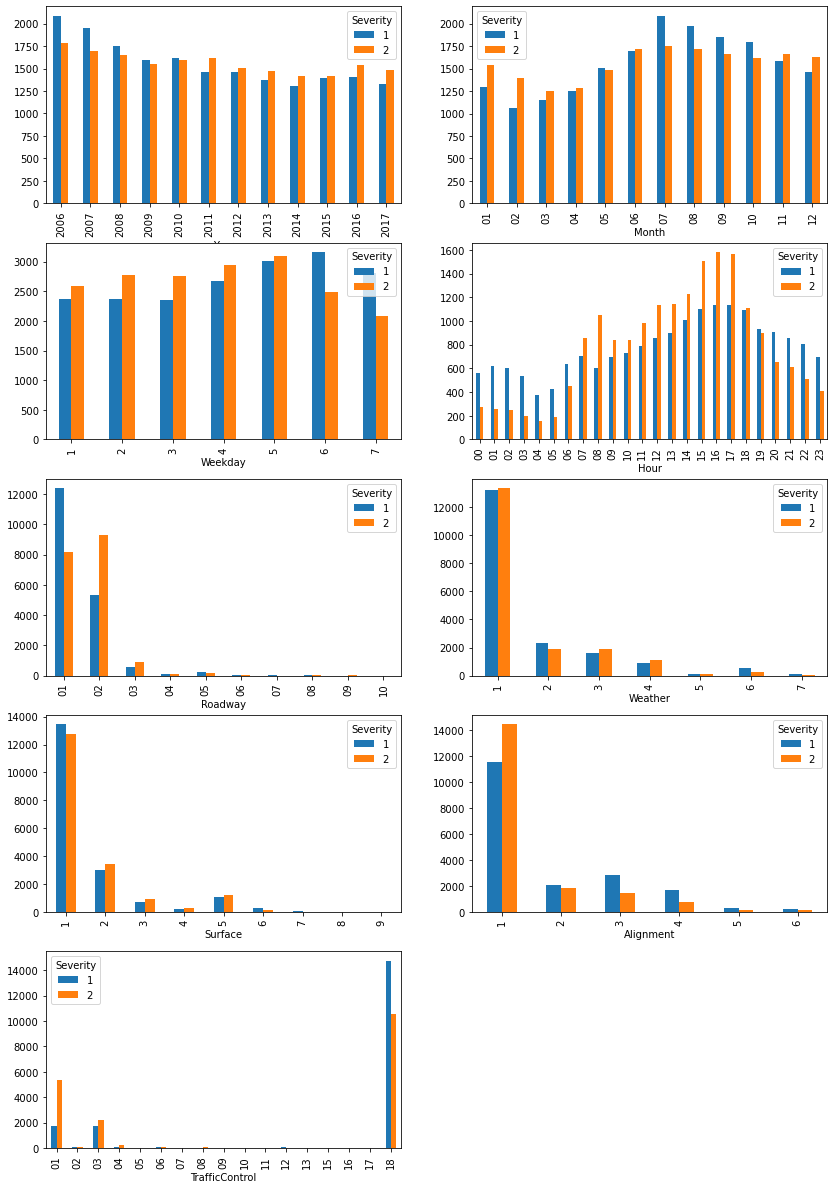

In [9]:
fig = plt.figure(figsize=(14,21))
for i, c in enumerate([c for c in df.columns if c != 'Severity']):
    ax = fig.add_subplot(5, 2, i + 1)
    ax.set_xlabel(c)
    (df[[c,'Severity']]
       .value_counts()
       .to_frame('Count')
       .reset_index()
       .pivot(index=c,columns='Severity',values='Count')
       .plot.bar(ax=ax))

<h3 id="methodology">Methodology</h3>
<ul>
<li>All the independent variables of interest are categorical. We use ANOVA to understand their influence on the target variable
<li>As a result of ANOVA analysis we rank all the variables according to their influence
<li>We have to derive indicator variables from categorical variables to be able to use Linear regression model on the next steps
<li>We use Linear regression model because it is the most simple model and the results are easily explainable
<li>We try to fit Linear regression model with different number of independent variables. Then we define an optimal number of independent variables according to the point after which we do not observe significant improvement in the model's R^2 score
</ul>

<h4>Data Normalization</h4>
<p>We will normalize the target variable only. This is the only numberical variable.</p>

In [10]:
from sklearn import preprocessing
df['Severity'] = preprocessing.scale(df['Severity'])

<h4>Indicator Variables Introduction</h4>
<p>Based on the ANOVA analysis we identified the influential categorical variables ranking.</p>
<p>Then we introduced indicator variables for these values. Indicator variables will allow us to build linear regression model.</p>

In [11]:
from scipy import stats

anova_results = {}
for i, c in enumerate([c for c in df.columns if c != 'Severity' and not isinstance(c, tuple)]):
    for val in df[c].unique():
        f_val, p_val = stats.f_oneway(df[df[c] == val]['Severity'], df['Severity'])
        anova_results[(c,val)] = (f_val, p_val)
anova_results = {
    k: v 
      for k, v in sorted(anova_results.items(), key=lambda item: item[1][0], reverse=True)
}
print("Categorical variables values ranking (first 5):")
import itertools
dict(itertools.islice(anova_results.items(), 5))

Categorical variables values ranking (first 5):


{('TrafficControl', '01'): (1603.1244454196565, 0.0),
 ('Roadway', '02'): (784.7761081519333, 2.0763718876401214e-171),
 ('Roadway', '01'): (560.3161707466681, 2.7634224967706845e-123),
 ('Alignment', '3'): (428.30447682320266, 1.1388198687063812e-94),
 ('TrafficControl', '18'): (422.27697751722644, 1.5862019198318086e-93)}

In [12]:
for k in anova_results.keys():
    df[k] = df[k[0]] == k[1]
df

,Year,Month,Weekday,Hour,Severity,Roadway,Weather,Surface,Alignment,TrafficControl,...,"(Surface, 9)","(TrafficControl, 07)","(Month, 04)","(Year, 2015)","(Hour, 18)","(Month, 06)","(Month, 05)","(Weather, 5)","(Year, 2010)","(Roadway, 10)"
0,2012,08,4,11,-1.0,01,2,1,3,18,...,False,False,False,False,False,False,False,False,False,False
1,2008,07,4,12,-1.0,01,2,1,1,18,...,False,False,False,False,False,False,False,False,False,False
2,2017,08,6,10,-1.0,01,1,1,1,18,...,False,False,False,False,False,False,False,False,False,False
3,2013,09,3,23,-1.0,01,1,1,4,18,...,False,False,False,False,False,False,False,False,False,False
4,2008,12,1,12,-1.0,02,1,1,3,18,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37451,2013,09,2,08,1.0,02,3,2,1,01,...,False,False,False,False,False,False,False,False,False,False
37452,2011,12,4,09,1.0,02,3,2,1,01,...,False,False,False,False,False,False,False,False,False,False
37453,2006,11,4,01,1.0,01,4,5,1,18,...,False,False,False,False,False,False,False,False,False,False
37454,2008,11,4,07,1.0,01,4,3,1,18,...,False,False,False,False,False,False,False,False,False,False


<h3 id="model_development">Model Development And Refinement</h3>

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[anova_results.keys()], df['Severity'], test_size=0.30, random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 11237
number of training samples: 26219


Text(0.5, 1.0, 'Increase in model accuracy with increase in variables number')

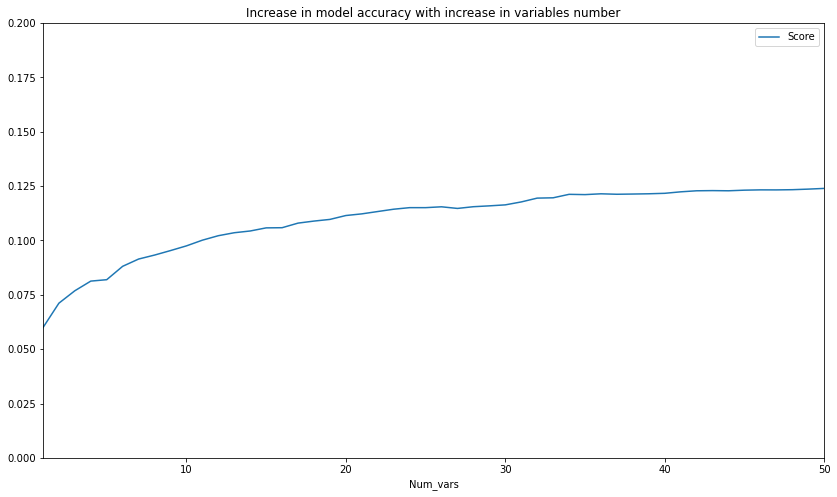

In [14]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
vars_scores = []
for i in range(1, len(anova_results)):
    vars = list(anova_results.keys())[:i]
    lm.fit(x_train[vars], y_train)
    score = lm.score(x_test[vars], y_test)
    vars_scores.append([i, score])
vars_scores_df = pd.DataFrame(vars_scores)
vars_scores_df.columns=['Num_vars', 'Score']
vars_scores_df.set_index('Num_vars', inplace=True)
# vars_scores_df
vars_scores_df.plot.line(figsize = (14,8))
axes = plt.gca()
axes.set_xlim([1,50])
axes.set_ylim([0,0.2])
axes.set_title('Increase in model accuracy with increase in variables number')

<h3 id="results">Results</h3>
<p>As we can see on the plot above, after ~40 variables the score is not improving significantly.</p>
<p>We built a final model with the following characteristics</p>

In [15]:
i = 40
vars = list(anova_results.keys())[:i]
lm.fit(x_train[vars], y_train)
print(f"R^2 Score: {lm.score(x_test[vars], y_test)}")
print(f"Negative coefficients increase chances of fatalities.\nPositive coefficients increase chances of non-fatal accidents.\nCoefficients:")
for (var, coef) in sorted(zip(vars, lm.coef_), key=lambda x: x[1]):
    print(f"    {coef} {var}")
print(f"Intercept: {lm.intercept_}")

R^2 Score: 0.12168081580891899
Negative coefficients increase chances of fatalities.
Positive coefficients increase chances of non-fatal accidents.
Coefficients:
    -0.3678255899762613 ('Hour', '03')
    -0.3586335762003413 ('Hour', '02')
    -0.3538602569337554 ('Hour', '05')
    -0.34857801920203185 ('Hour', '01')
    -0.27197751058486924 ('Hour', '00')
    -0.2617015023589154 ('Hour', '04')
    -0.24456282248558017 ('Weather', '6')
    -0.22188684037946635 ('Hour', '22')
    -0.21798528537553993 ('Alignment', '5')
    -0.2143710480468158 ('Surface', '6')
    -0.213114296342077 ('Hour', '23')
    -0.1935170839225154 ('Alignment', '4')
    -0.1930277960824357 ('Hour', '21')
    -0.17307203157873943 ('Hour', '20')
    -0.16325975602171774 ('Hour', '06')
    -0.16018200351944828 ('Alignment', '6')
    -0.13841317638127776 ('Alignment', '3')
    -0.08049623919143728 ('Roadway', '01')
    -0.0697283638225513 ('Weekday', '7')
    -0.053010695036939816 ('Month', '07')
    -0.04507731879481

<p>Notes decoding the values:</p>
<ul>
    <li>('Alignment', '1') - the road is Straight and level
    <li>('Alignment', '3') - the road is Curved and level
    <li>('Alignment', '4') - the road is Curved with gradient
    <li>('Alignment', '5') - Top of hill or gradient
    <li>('Alignment', '6') - Bottom of hill or gradient "Sag"
    <li>('Roadway', '01') - Non-intersection e.g. mid-block
    <li>('Roadway', '02') - At an intersection of at least two public roadways
    <li>('Roadway', '03') - Intersection with parking lot entrance/exit, private driveway or laneway
    <li>('Surface', '2') - Wet surface
    <li>('Surface', '3') - Snow (fresh, loose snow)
    <li>('Surface', '6') - Sand/gravel/dirt Refers to the debris on the road, not the material used to construct the road
    <li>('Weather', '2') - Overcast, cloudy but no precipitation
    <li>('Weather', '3') - Raining
    <li>('Weather', '4') - Snowing, not including drifting snow
    <li>('Weather', '6') - Visibility limitation e.g. drifting snow, fog, smog, dust, smoke, mist
    <li>('TrafficControl', '01') - Traffic signals fully operational
    <li>('TrafficControl', '03') - Stop sign
    <li>('TrafficControl', '04') - Yield sign
    <li>('TrafficControl', '08') - School guard, flagman
    <li>('TrafficControl', '18') - No control present
    <li>Weekday / Hour / Month - numbers correspond to the literal linguistical usage and meaning. Monday has a weekday number of 1
</ul>

<h3 id="discussion">Discussion and interpretation</h3>
<p>Having the R^2 score of 0.1, model is not good at predictions of fatalities. However, the model is good enough for identification of important factors and their role in fatalities on the roads.</p>
<p>We can speculate that the fundamental factors behind all the identified influential independent variables are speed and visibility.</p>
<h4>Observations:</h4>
<ul>
    <li>Night hours are the worst of all the factors. Low traffic leads to higher speeds. Lack of visibility makes driving even riskier.
    <li>Traffic controls significantly decrease the traffic speed and thus fatalities.
    <li>Weekend traffic is low and speedy. Risk of fatalities is higher.
    <li>Presence of Sand/gravel/dirt on the road is not expected by the drivers and prooves to be dangerous.
    <li>Roads curvature decreases visibility. Risk of fatalities is higher.
    <li>Overcast weather as well as drifting snow, fog, smog, dust, smoke, mist decrease visibility. Risk of fatalities is higher.
    <li>Raining and snowing (not including drifting snow) descrease visibility, but also significantly decrease the speed of the traffic. Drivers are extra careful. The risk of fatalities is lower.
</ul>
<h4>Recommendations to drivers:</h4>
<ul>
    <li>Avoid driving at night
    <li>Avoid driving in conditions with low visibility
    <li>Respect traffic controls
</ul>
<h4>Recommendations to traffic planners:</h4>
<ul>
    <li>Install traffic controls extensively
    <li>Avoid sharp road curvatures when designing roads. Try to keep roads straight and level
    <li>Controls are required to keep the roads clean. Presence of extraneous materials proves to be dangerous
</ul>

<h3 id="conclusion">Conclusion</h3>
<p>In this project we explored Canadian National Collision Database dataset. We analyzed available attributes. We preprocessed data. We chose features and built a linear regression model for the car accidents severity. We were able to give practical and sensible data-based recommendations to drivers an traffic planners, thus successfully reaching the goals of this project.</p>